**Installs**

In [1]:
!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'

     |████████████████████████████████| 734.6MB 14kB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 1.3.1 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
     |████████████████████████████████| 753.4MB 14kB/s 
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
     |████████████████████████████████| 634kB 3.3MB/s 
  Created wheel for Pillow-SIMD: filename=Pillow_SIMD-7.0.0.post3-cp36-cp36m-linux_x86_64.whl size=1110545 sha256=2606c119dfe49931d35008c100244b0ac57be3ac5e74f9bfec6b1c9501725587
  Stored in directory: /root/.cache/pip/wheels/d3/ac/4f/4cdf8febba528e5f1b09fc58d5181e1c12ed1e8655dcd583b8
Successfully built Pillow-SIMD


**Imports**

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms
from torchvision.models import googlenet


from PIL import Image
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import copy

#NUM_CLASSES = 102
NUM_CLASSES = 6
DEVICE = 'cuda'
MOMENTUM = 0.9

**Model definition**

In [0]:
def get_datasets(train_data_dir, test_data_dir, compose=[#transforms.Resize(224),
                                                         transforms.CenterCrop(224),
                                                         transforms.ToTensor()#,
                                                         #transforms.Normalize((75.29522728, 26.30439561, 70.34910019), (80.67869619, 35.54419227, 54.88938911))
                                                         ]):
    train_transform = transforms.Compose(compose)
    eval_transform = transforms.Compose([
          #transforms.Resize(224),
          transforms.CenterCrop(224),
          transforms.ToTensor()
          ])


    if not os.path.isdir('./AIML_project'):
        !git clone https://github.com/anphetamina/AIML_project.git
    
    train_dataset = torchvision.datasets.ImageFolder(train_data_dir, transform=train_transform)
    test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform=eval_transform)

    return train_dataset, test_dataset

def test_network(net, test_dataset, batch_size):
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    net.train(False)

    criterion = nn.CrossEntropyLoss()

    sum_test_losses = 0.0
    running_corrects = 0
    for images, labels in test_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)

      # Forward Pass
      outputs = net(images)
      if (hasattr(outputs, 'logits')):
        outputs = outputs.logits

      # Get predictions
      _, preds = torch.max(outputs, 1)
      test_loss = criterion(outputs, labels)
      sum_test_losses += test_loss.item()*images.size(0)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataset))

    # Calculate loss
    test_loss = sum_test_losses / float(len(test_dataset))

    return accuracy, test_loss

def train_network(net, parameters_to_optimize, learning_rate, num_epochs, batch_size, weight_decay, step_size, gamma, train_dataset, val_dataset=None, verbosity=False, plot=False):
  
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(parameters_to_optimize, lr=learning_rate, momentum=MOMENTUM, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    net = net.to(DEVICE)
    best_net = googlenet()
    best_net = best_net.to(DEVICE)
    #best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)

    cudnn.benchmark

    train_accuracies = []
    train_losses = []
    val_accuracies = []
    val_losses = []

    current_step = 0
    best_val_accuracy = 0.0
    best_val_loss = 0.0
    for epoch in range(num_epochs):

        train_running_corrects = 0
        sum_train_losses = 0.0

        for images, labels in train_dataloader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            net.train()
            optimizer.zero_grad()

            outputs = net(images)
            if (hasattr(outputs, 'logits')):
              outputs = outputs.logits
            
            _, preds = torch.max(outputs, 1)
            train_running_corrects += torch.sum(preds == labels.data).data.item()
            loss = criterion(outputs, labels)
            sum_train_losses += loss.item()*images.size(0)
            loss.backward()

            optimizer.step()
            current_step += 1
        
        if val_dataset is not None:
            val_accuracy, val_loss = test_network(net, val_dataset, batch_size)
            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_val_loss = val_loss
                best_net.load_state_dict(net.state_dict())
            val_accuracies.append(val_accuracy)
            val_losses.append(val_loss)

        # Calculate accuracy on train set
        train_accuracy = train_running_corrects / float(len(train_dataset))
        train_accuracies.append(train_accuracy)

        # Calculate loss on training set
        train_loss = sum_train_losses/float(len(train_dataset))
        train_losses.append(loss)

        if verbosity:
            if val_dataset is not None:
                print("train_acc: {}, val_acc: {}, train_loss: {}, val_loss: {} ({} / {})".format(train_accuracy, val_accuracy, train_loss, val_loss, epoch+1, num_epochs))
            else:
                print("train_acc: {}, train_loss: {} ({} / {})".format(train_accuracy, train_loss, epoch+1, num_epochs))

        scheduler.step()

    if plot:

        fig, ax = plt.subplots()
        line1, = ax.plot(train_losses, label='Loss on training set')
        line2, = ax.plot(train_accuracies, label='Accuracy on training set')
        ax.legend()
        plt.xlabel("Epochs")
        plt.show()

        if val_dataset is not None:
            fig, ax = plt.subplots()
            line1, = ax.plot(val_accuracies, label='Accuracy on validation set', color='C2')
            line2, = ax.plot(train_accuracies, label='Accuracy on training set', color='C3')
            ax.legend()
            plt.xlabel("Epochs")
            plt.show()
        
            fig, ax = plt.subplots()
            line1, = ax.plot(val_losses, label='Loss on validation set', color='C1')
            line2, = ax.plot(train_losses, label='Loss on training set', color='C7')
            ax.legend()
            plt.xlabel("Epochs")
            plt.show()

    
    return best_net, best_val_accuracy, best_val_loss


**Train + validation**

training set 910
validation set 102
train_acc: 0.1956043956043956, val_acc: 0.22549019607843138, train_loss: 5.737951856131082, val_loss: 4.086929209092084 (1 / 100)
train_acc: 0.27692307692307694, val_acc: 0.3235294117647059, train_loss: 3.182013045824491, val_loss: 2.316683900122549 (2 / 100)
train_acc: 0.33186813186813185, val_acc: 0.3627450980392157, train_loss: 2.0602012152200215, val_loss: 1.7823754946390789 (3 / 100)
train_acc: 0.35604395604395606, val_acc: 0.4117647058823529, train_loss: 1.7589265039988926, val_loss: 1.5784294932496314 (4 / 100)
train_acc: 0.37032967032967035, val_acc: 0.38235294117647056, train_loss: 1.6043960636788672, val_loss: 1.554998797528884 (5 / 100)
train_acc: 0.3967032967032967, val_acc: 0.23529411764705882, train_loss: 1.5172669979242177, val_loss: 2.0342542096680285 (6 / 100)
train_acc: 0.4021978021978022, val_acc: 0.43137254901960786, train_loss: 1.4933238388417842, val_loss: 1.3541285734550625 (7 / 100)
train_acc: 0.4197802197802198, val_acc: 0.34

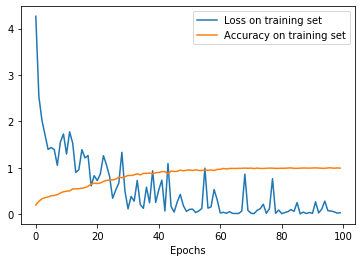

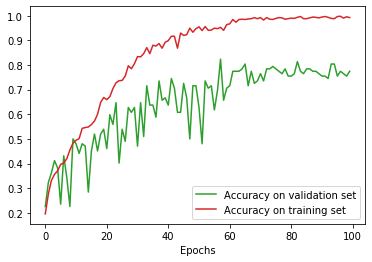

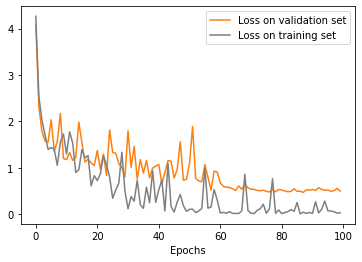

val accuracy 0.8235294117647058
val loss 0.516998720519683


In [9]:
BATCH_SIZE = 8
LR = 0.0001
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-5 #was e-5
NUM_EPOCHS = 100
STEP_SIZE = 60 #was 60
GAMMA = 0.1 #was 0.08

TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-224'
#TRAIN_DATA_DIR = 'Homework2-Caltech101/101_ObjectCategories'
compose=[#transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.RandomGrayscale(),
         transforms.ColorJitter(brightness=0.5, contrast=0.5),
         transforms.ToTensor()
         ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)
train_indexes = [idx for idx in range(len(train_dataset)) if idx % 10]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 10]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))

net = googlenet()
#net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_net, val_accuracy, val_loss = train_network(net, net.parameters(), LR, NUM_EPOCHS, BATCH_SIZE, WEIGHT_DECAY, STEP_SIZE, GAMMA, train_dataset, val_dataset=val_dataset, verbosity=True, plot=True)

print('val accuracy {}'.format(val_accuracy))
print('val loss {}'.format(val_loss))

**Testing**

In [0]:
# todo

**Grid search**

In [6]:
NUM_CLASSES = 6
DEVICE = 'cuda'
#BATCH_SIZE = 16
#LR = 0.001
MOMENTUM = 0.9
#WEIGHT_DECAY = 5e-5
NUM_EPOCHS = 100
STEP_SIZE = 60
#GAMMA = 0.1

lr_range = [0.001, 0.05]
batch_size_range = [32, 128] #was 16, 32
weight_decay_range = [1e-5, 1e-3] #was 
gamma_range = [0.08, 0.8] #was 0.08, 0.1
hyperparameters_sets = []

for lr in lr_range:
  for batch_size in batch_size_range:
    for weight_decay in weight_decay_range:
      for gamma in gamma_range:
        hyperparameters_sets.append({'lr': lr, 'batch_size': batch_size, 'weight_decay': weight_decay, 'gamma': gamma})

for set in hyperparameters_sets:
  print(set)


TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-spec-224'
compose=[#transforms.Resize(224),
         transforms.CenterCrop(224),
         transforms.RandomGrayscale(),
         transforms.ColorJitter(brightness=0.5, contrast=0.5),
         transforms.ToTensor()
         ]
train_dataset, val_dataset = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, compose)

train_indexes = [idx for idx in range(len(train_dataset)) if idx % 5]
val_indexes = [idx for idx in range(len(train_dataset)) if not idx % 5]
val_dataset = Subset(val_dataset, val_indexes)
train_dataset = Subset(train_dataset, train_indexes)
print('training set {}'.format(len(train_dataset)))
print('validation set {}'.format(len(val_dataset)))

best_net = googlenet()
best_net = best_net.to(DEVICE)
#best_net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
best_set = {}
best_accuracy = 0.0
best_loss = 0.0
val_accuracies = []
val_losses = []

for set in hyperparameters_sets:

  net = googlenet()
  #net.classifier[6] = nn.Linear(4096, NUM_CLASSES)
  current_net, val_accuracy, val_loss = train_network(net, net.parameters(), set['lr'], NUM_EPOCHS, set['batch_size'], set['weight_decay'], STEP_SIZE, set['gamma'], train_dataset, val_dataset=val_dataset, verbosity=True)
  val_accuracies.append(val_accuracy)
  val_losses.append(val_loss)

  if val_accuracy > best_accuracy:
    best_accuracy = val_accuracy
    best_loss = val_loss
    best_net = copy.deepcopy(current_net)
    best_set = copy.deepcopy(set)
  
  print("({}), val accuracy {}, val loss {}".format(set, val_accuracy, val_loss))

print("\n({}), best val accuracy {}, best val loss {}".format(best_set, best_accuracy, best_loss))
print("\nval_accuracies")
print(val_accuracies)

{'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-05, 'gamma': 0.08}
{'lr': 0.001, 'batch_size': 32, 'weight_decay': 1e-05, 'gamma': 0.8}
{'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.001, 'gamma': 0.08}
{'lr': 0.001, 'batch_size': 32, 'weight_decay': 0.001, 'gamma': 0.8}
{'lr': 0.001, 'batch_size': 128, 'weight_decay': 1e-05, 'gamma': 0.08}
{'lr': 0.001, 'batch_size': 128, 'weight_decay': 1e-05, 'gamma': 0.8}
{'lr': 0.001, 'batch_size': 128, 'weight_decay': 0.001, 'gamma': 0.08}
{'lr': 0.001, 'batch_size': 128, 'weight_decay': 0.001, 'gamma': 0.8}
{'lr': 0.05, 'batch_size': 32, 'weight_decay': 1e-05, 'gamma': 0.08}
{'lr': 0.05, 'batch_size': 32, 'weight_decay': 1e-05, 'gamma': 0.8}
{'lr': 0.05, 'batch_size': 32, 'weight_decay': 0.001, 'gamma': 0.08}
{'lr': 0.05, 'batch_size': 32, 'weight_decay': 0.001, 'gamma': 0.8}
{'lr': 0.05, 'batch_size': 128, 'weight_decay': 1e-05, 'gamma': 0.08}
{'lr': 0.05, 'batch_size': 128, 'weight_decay': 1e-05, 'gamma': 0.8}
{'lr': 0.05, 'batch_size': 

FileNotFoundError: ignored

**Testing**

In [0]:
# todo

**Mean / std computation**

In [0]:
TRAIN_DATA_DIR = 'AIML_project/ravdess-emotional-song-mel'
pixel_mean = np.zeros(3)
pixel_std = np.zeros(3)
k = 1
dataset, _ = get_datasets(TRAIN_DATA_DIR, TRAIN_DATA_DIR, [])
for image, _ in tqdm(dataset, "Computing mean/std", len(dataset), unit="samples"):
    image = np.array(image)
    pixels = image.reshape((-1, image.shape[2]))

    for pixel in pixels:
        diff = pixel - pixel_mean
        pixel_mean += diff / k
        pixel_std += diff * (pixel - pixel_mean)
        k += 1

pixel_std = np.sqrt(pixel_std / (k - 2))
print(pixel_mean)
print(pixel_std)